<a href="https://colab.research.google.com/github/gracetzeng/neural-networks-demystified/blob/main/Neural_Networks_Demystified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Networks Demystified - Series by Welch Labs**

Completed by me (Grace!) on 12/26/24 and 12/27/24

**Supervised Regression**

Predict test score based on # of hours slept and # of hours studied

Supervised: our examples have inputs and outputs

Regression: test scores are a continuous output (vs. a discrete output, like letter grades)

In [104]:
# import matplotlib and numpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# **Part 1: Data and Architecture**

In [105]:
# X = (hours slept, hours studied), y = score on test
X = np.array(([3,5], [5, 1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)
print(X)
print(y)

[[ 3.  5.]
 [ 5.  1.]
 [10.  2.]]
[[75.]
 [82.]
 [93.]]


Because of the difference in units between our data (inputs are hours and output is a number between 0-100), we need to scale the data. Since all of the data is positive, we can divide by the maximum value for each variable so the data falls between 0 and 1.

In [106]:
X = X/np.amax(X, axis=0) # set axis = 0 so it finds the max for each variable and not each pair
y = y/100

In [107]:
print(X)
print(y)

[[0.3 1. ]
 [0.5 0.2]
 [1.  0.4]]
[[0.75]
 [0.82]
 [0.93]]


# **Part 2: Forward Propogation**

Our network will have 2 inputs, 3 hidden units, and 1 output. We decide on the number of hidden units/layers, and the neural network will decide on the weights of the synapses between neurons. We will use a class to represent the neural network.

*Sigmoid function*:

<center>$\boxed{ \large z^{(2)} = XW^{(1)}} \: (1)$

Where $z^{(2)}$ is the activity for the second layer, $X$ is the inputs, and $W^{(1)}$ is the weights. Each entry in $z^{(2)}$ is a sum of weighted inputs to each neuron.

A sigmoid activation function bounds its output from 0 to 1.

<center> $f(z) = \frac{1}{1 + e^{-z}}$

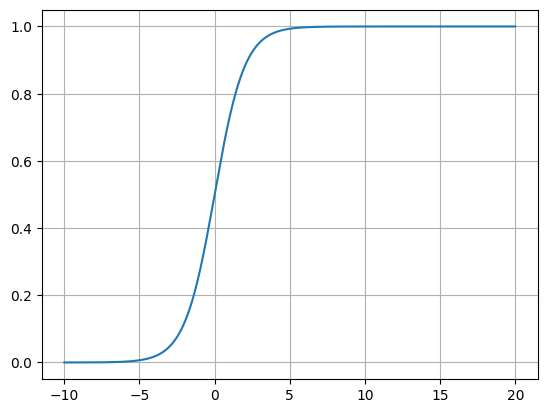

In [108]:
# numpy will accept a scalar, vector, or matrix!
def sigmoid(z):
    return 1/(1+np.exp(-z))

testInput = np.arange(-10, 20, 0.01)
plot(testInput, sigmoid(testInput))
grid(1)

*Forward function*: This function will move our data as matrices through the network. If we can represent our synapse weights as a matrix, then we can easily matrix multiply these weights with the input X to get our output vector.

Now that we have the activities of the second layer, we need to apply the activation function, where $a^{(2)}$, the second layer activity, is equal to $f(z^{(2)})$. $a^{(2)}$ has the same size as $z^{(2)}$.

<center>$\boxed{ \large a^{(2)} = f(z^{(2)})} \: (2)$</center>

To finish forward propogation, we need to propogate $a^{(2)}$ to the output, y hat. First, multiply $a^{(2)}$ by the second layer weights, $W^{(2)}$:

<center>$\boxed{ \large z^{(3)} = a^{(2)}W^{(2)}} \: (3)$

Then, apply one more activation function to $z^{(3)}$ to get 1 output (as determined by us):

<center>$\boxed{ \large \hat{y} = f(z^{(3)})} \: (4)$



---


The current neural network class!

In [109]:
class Neural_Network(object):
  def __init__(self):
    self.inputLayerSize = 2
    self.outputLayerSize = 1
    self.hiddenLayerSize = 3

    # weight matrices; starting off with random numbers
    self.W1 = np.random.rand(self.inputLayerSize, self.hiddenLayerSize)
    self.W2 = np.random.rand(self.hiddenLayerSize, self.outputLayerSize)

  # propogate inputs through network
  def forward(self, X):
    self.z2 = np.dot(X, self.W1)
    self.a2 = sigmoid(self.z2)
    self.z3 = np.dot(self.a2, self.W2)
    yHat = sigmoid(self.z3)
    return yHat

  # sigmoid activation function
  def sigmoid(z):
    return 1/(1+np.exp(-z))

#**Part 3: Gradient Descent**

Without training our model, its predictions are quite inaccurate.

In [110]:
NN = Neural_Network()
yHat = NN.forward(X)
print(yHat)
print(y)

[[0.74943718]
 [0.7389799 ]
 [0.77210937]]
[[0.75]
 [0.82]
 [0.93]]


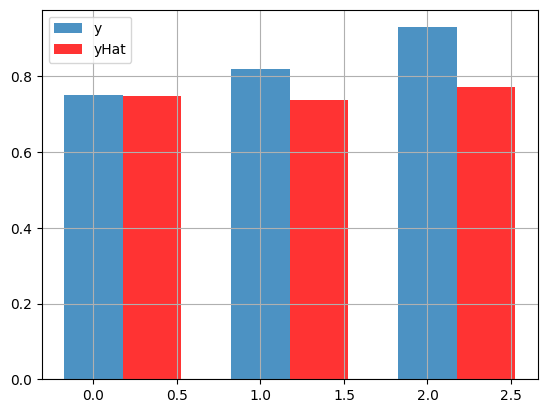

In [111]:
# compare model's estimates to actual score
bar([0,1,2], y.flatten(), width=0.35, alpha=0.8) # np flatten converts multi-dim array to 1D array
bar([0.35,1.35,2.35], yHat.flatten(), width=0.35, color='r', alpha=0.8)
grid(1)
legend(['y', 'yHat'])

In order to improve our model, we need to quantify how wrong its predictions are. A **cost function** will allow us to express how wrong or costly our model is. One way to compute cost is to square each value's error and add them together. Multiplying by 1/2 will make things simpler later (exponent cancelled when we differentiate).

<center>$\boxed{ \large J = \sum{}\frac{1}{2}(y-\hat{y})^2 } \: (5)$

Training a network means to minimize a cost function. Our cost function depends on our examples and the weights on the synapses. We can't really change the data, so we will change the weights to minimize cost.

We have 5 equations, but they're essentially 1 big equation! We can use calculus to figure out which way the weights should move (increase or decrease) to minimize cost. i.e., find the rate of change of $J$ w/r/t $W$. This is a partial derivative because we have two weight matrices.

<center> $J = \sum{}\frac{1}{2}(y- f(f(XW^{(1)})W^{(2)}))^2$

<center> $\frac{\partial J}{\partial W}$

Since we know which direction the cost decreases, we can find the best weights faster! To make it even faster, we can stop searching when the cost stops getting smaller (rate of change = 0). This method is called **gradient descent**. We want to find the global minimum of the cost function.

Problem: If we have a **non-convex** (having multiple peaks/valleys) cost function, the gradient descent algorithm may get stuck in a local minimum instead of the global minimum. BUT, by using the sum of squares, we make sure that **the cost function is convex**. If we use our examples one at a time, sometimes it won't matter if the function is convex. This is called **stochastic gradient descent**.

We will be using **batch gradient descent**, where we use our examples all at once.

# **Part 4: Backpropogation**

We will compute $\frac{\partial J}{\partial W^{(1)}}$ and $\frac{\partial J}{\partial W^{(2)}}$ independently. Both will be the same size as their respective $W$ matrix.



---


**Calculating $\frac{\partial J}{\partial W^{(2)}}$**

Move sigma outside:
<center>$\frac{\partial J}{\partial W^{(2)}} = \sum{}\frac{\partial \frac{1}{2} (y-\hat{y})^{1/2}}{\partial W^{(2)}}$ </center>

Let's ignore the summation for now.
<center> $= -(y-\hat{y}) \frac{\partial \hat{y}}{\partial W^{(2)}}$</center>

We know from Equation 4 that $\hat{y}$ is our activation function of $z^{(3)}$:
<center> $= -(y-\hat{y}) \frac{\partial \hat{y}}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial W^{(2)}}$</center>

We now need to differentiate our sigmoid activation function:
<center> $f(z) = \frac{1}{1 + e^{-z}}$ </center>
<center> $f'(z) = \frac{e^{-z}}{(1 + e^{-z})^{2}}$ </center>

Now we have:
<center> $= -(y-\hat{y}) f'(z^{(3)}) \frac{\partial z^{(3)}}{\partial W^{(2)}}$</center>

We know $z^{(3)} = a^{(2)}W^{(2)}$, so $\frac{\partial z^{(3)}}{\partial W^{(2)}} = a^{(2)}$. But we need to be careful with dimensions! $-(y-\hat{y})$ and $f'(z^{(3)})$ are both 3x1, but we are scalar multiplying them. This resulting 3x1 matrix is called the **backpropagating error**, or $\delta^{(3)}$. Since we need to multiply each value in $\delta^{(3)}$ by each activity, we can take the transpose of $a^{(2)}$ and matrix multiply with $\delta^{(3)}$:
<center>$\delta^{(3)} = -(y-\hat{y}) f'(z^{(3)})$</center>

<center> $\boxed{ \large \frac{\partial J}{\partial W^{(2)}} = (a^{(2)})^T \delta^{(3)} } \:(6)$</center>

We don't need to worry about the summation anymore because the matrix multiplication adds up the $\frac{\partial J}{\partial W^{(2)}}$ terms from all our examples!



---

**Calculating $\frac{\partial J}{\partial W^{(1)}}$**

<center>$\frac{\partial J}{\partial W^{(1)}} = \sum{}\frac{\partial \frac{1}{2} (y-\hat{y})^{1/2}}{\partial W^{(1)}}$ </center>

<center> $= -(y-\hat{y}) \frac{\partial \hat{y}}{\partial W^{(1)}}$</center>

<center> $= -(y-\hat{y}) \frac{\partial \hat{y}}{\partial z^{(3)}} \frac{\partial z^{(3)}}{\partial W^{(1)}}$</center>

<center> $= -(y-\hat{y}) f'(z^{(3)}) \frac{\partial z^{(3)}}{\partial W^{(1)}}$</center>

<center> $= -(y-\hat{y}) f'(z^{(3)}) \frac{\partial z^{(3)}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial W^{(1)}}$</center>

<center> $= -(y-\hat{y}) f'(z^{(3)}) \frac{\partial z^{(3)}}{\partial a^{(2)}} \frac{\partial a^{(2)}}{\partial W^{(1)}}$</center>

Since $\delta^{(3)} = -(y-\hat{y}) f'(z^{(3)})$ and $\frac{\partial z^{(3)}}{\partial a^{(2)}}$ comes out to be the weight for that synapse:

<center> $= \delta^{(3)} (W^{(2)})^{T} \frac{\partial a^{(2)}}{\partial W^{(1)}}$</center>

Now for the $\frac{\partial a^{(2)}}{\partial W^{(1)}}$ term:

<center> $= \delta^{(3)} (W^{(2)})^{T} \frac{\partial a^{(2)}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial W^{(1)}}$</center>

<center> $= \delta^{(3)} (W^{(2)})^{T} f'(z^{(2)}) \frac{\partial z^{(2)}}{\partial W^{(1)}}$</center>

Since $\frac{\partial z^{(2)}}{\partial W^{(1)}} = X$, we can use a similar method as before and multiply by X transpose:

<center> $= X^T \delta^{(3)} (W^{(2)})^{T} f'(z^{(2)})$</center>

Let $\delta^{(2)} = \delta^{(3)} (W^{(2)})^{T} f'(z^{(2)})$:


<center>$\boxed{\large \frac{\partial J}{\partial W^{(1)}} = X^T \delta^{(2)}}$ (7)



---



In [112]:
# derivative of sigmoid function
def sigmoidPrime(z):
  return np.exp(-z)/((1 + np.exp(-z)) ** 2)

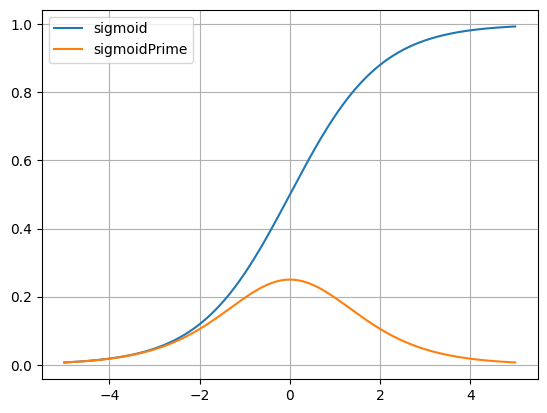

In [113]:
testVals = np.arange(-5, 5, 0.01)
plot(testVals, sigmoid(testVals))
plot(testVals, sigmoidPrime(testVals))
grid(1)
legend(["sigmoid", "sigmoidPrime"])

By multiplying the activity on each synapse, the weights that contribute more to the overall error will have larger activiations and larger $\frac{\partial J}{\partial W^{(2)}}$ values. Thus, they will be changed more when we perform gradient descent.

In [114]:
# compute derivate w/r/t W1 and W2
def costFunctionPrime(self, X, y):
  self.yHat = self.forward(X)

  delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
  dJdW2 = np.dot(self.a2.T, delta3)

  delta2 = np.dot(delta3, self.W2.T) * self.sigmoidPrime(self.z2)
  dJddW1 = np.dot(X.T, delta2)

  return dJdW1, dJdW2



---


The finished neural network class!


In [115]:
class Neural_Network(object):
  def __init__(self):
    self.inputLayerSize = 2
    self.outputLayerSize = 1
    self.hiddenLayerSize = 3

    # weight matrices; starting off with random numbers
    self.W1 = np.random.rand(self.inputLayerSize, self.hiddenLayerSize)
    self.W2 = np.random.rand(self.hiddenLayerSize, self.outputLayerSize)

  # propogate inputs through network
  def forward(self, X):
    self.z2 = np.dot(X, self.W1)
    self.a2 = sigmoid(self.z2)
    self.z3 = np.dot(self.a2, self.W2)
    yHat = sigmoid(self.z3)
    return yHat

  # sigmoid activation function
  def sigmoid(self, z):
    return 1/(1+np.exp(-z))

  # derivative of sigmoid function
  def sigmoidPrime(self, z):
    return np.exp(-z)/((1 + np.exp(-z)) ** 2)

  # compute J, the cost
  def costFunction(self, X, y):
    self.yHat = self.forward(X)
    J = 0.5 * sum((y - self.yHat) ** 2)
    return J

  # compute derivate w/r/t W1 and W2
  def costFunctionPrime(self, X, y):
    self.yHat = self.forward(X)

    delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
    dJdW2 = np.dot(self.a2.T, delta3)

    delta2 = np.dot(delta3, self.W2.T) * self.sigmoidPrime(self.z2)
    dJdW1 = np.dot(X.T, delta2)

    return dJdW1, dJdW2

We can now adjust the weights to minimize the cost!

In [116]:
NN = Neural_Network()
cost1 = NN.costFunction(X, y)
dJdW1, dJdW2 = NN.costFunctionPrime(X, y)

In [117]:
print(dJdW1)
print(dJdW2)

[[-3.86370923e-03 -4.40896096e-03 -2.13600844e-03]
 [-1.18161631e-04 -5.02541027e-05  7.53832088e-05]]
[[-0.00970186]
 [-0.00987191]
 [-0.01248685]]


If we add to our weights a scalar times our gradient, the cost increases. If we subtract from our weights a scalar times our gradient, we can reduce our cost.

In [118]:
scalar = 3
NN.W1 = NN.W1 + scalar * dJdW1
NN.W2 = NN.W2 + scalar * dJdW2
cost2 = NN.costFunction(X,y)
print(cost1, cost2) # cost should increase

0.010522438441870889 0.011866940691175236


In [119]:
dJW1, dJW2 = NN.costFunctionPrime(X, y)
NN.W1 = NN.W1 - scalar * dJW1
NN.W2 = NN.W2 - scalar * dJW2
cost3 = NN.costFunction(X, y)
print(cost1, cost3) # cost should decrease

0.010522438441870889 0.01016718722243376


# **Part 5: Numerical Gradient Checking**

Our neural network has no way to tell us if we made an error when implementing our gradient; it may still function just fine. We can test the gradient computation part of our code. If our code passes this test called **numerical gradient checking**, then we can be confident that we implemented the gradients correctly.

We will pick a point in the middle of the interval we want to test and call the difference in either direction epsilon. Since the definition of a derivative is like the slope formula, we can calculate the slope between the two points around the middle point and compare this with the actual slope at the middle point.

Let's first test with the function $x^2$. We will chose our point to be $x = 1.5$, and epsilon to be .0001. Then, we will compute the slope between x + epsilon and x - epsilon, and compare this with the actual derivative $2x$.

In [120]:
def f(x):
  return x ** 2

In [121]:
epsilon = 1e-4
x = 1.5
numericalGradient = (f(x + epsilon) - f(x - epsilon)) / (2 * epsilon)

In [122]:
numericalGradient, 2*x # the values should be very close to each other!

(2.9999999999996696, 3.0)

Now, let's apply this method to our neural network to numerically evaluate its gradient! Since we have 9 gradient values, it will be more complicated. First, we will add some helper functions to our class.

In [123]:
class Neural_Network(object):
  def __init__(self):
    self.inputLayerSize = 2
    self.outputLayerSize = 1
    self.hiddenLayerSize = 3

    # weight matrices; starting off with random numbers
    self.W1 = np.random.rand(self.inputLayerSize, self.hiddenLayerSize)
    self.W2 = np.random.rand(self.hiddenLayerSize, self.outputLayerSize)

  # propogate inputs through network
  def forward(self, X):
    self.z2 = np.dot(X, self.W1)
    self.a2 = sigmoid(self.z2)
    self.z3 = np.dot(self.a2, self.W2)
    yHat = sigmoid(self.z3)
    return yHat

  # sigmoid activation function
  def sigmoid(self, z):
    return 1/(1+np.exp(-z))

  # derivative of sigmoid function
  def sigmoidPrime(self, z):
    return np.exp(-z)/((1 + np.exp(-z)) ** 2)

  # compute J, the cost
  def costFunction(self, X, y):
    self.yHat = self.forward(X)
    J = 0.5 * sum((y - self.yHat) ** 2)
    return J

  # compute derivate w/r/t W1 and W2
  def costFunctionPrime(self, X, y):
    self.yHat = self.forward(X)

    delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
    dJdW2 = np.dot(self.a2.T, delta3)

    delta2 = np.dot(delta3, self.W2.T) * self.sigmoidPrime(self.z2)
    dJdW1 = np.dot(X.T, delta2)

    return dJdW1, dJdW2

  # class helper functions
  def getParams(self):
    params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
    return params

  def setParams(self, params):
    W1_start = 0
    W1_end = self.inputLayerSize * self.hiddenLayerSize
    self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize, self.hiddenLayerSize))
    W2_end = W1_end + self.hiddenLayerSize * self.outputLayerSize
    self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))

  def computeGradients(self, X, y):
    dJdW1, dJdW2 = self.costFunctionPrime(X, y)
    return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

Next, we will write the function to compute the numerical gradient. This process will repeat for all our weights.

In [124]:
def computeNumericalGradient(N, X, y):
  paramsInitial = N.getParams()
  numgrad = np.zeros(paramsInitial.shape)
  perturb = np.zeros(paramsInitial.shape)
  e = 1e-4

  for p in range(len(paramsInitial)):
    perturb[p] = e  # set pertubation vector

    # add epsilon and compute the cost function
    N.setParams(paramsInitial + perturb)
    loss2 = N.costFunction(X, y)

    # subtract epsilon and compute the cost function
    N.setParams(paramsInitial - perturb)
    loss1 = N.costFunction(X, y)

    numgrad[p] = (loss2 - loss1) / (2 * e)  # compute numerical gradient (slope between the 2 values)
    perturb[p] = 0  # return the value to 0

  N.setParams(paramsInitial)  # return params to original values
  return numgrad

In [125]:
NN = Neural_Network()
numgrad = computeNumericalGradient(NN, X, y)
numgrad

array([-0.01219827, -0.00211769, -0.0018696 , -0.00653876, -0.00112657,
       -0.00099226, -0.05905807, -0.05014273, -0.05702495])

In [126]:
grad = NN.computeGradients(X, y)
grad

array([-0.01219827, -0.00211769, -0.0018696 , -0.00653876, -0.00112657,
       -0.00099226, -0.05905807, -0.05014273, -0.05702495])

The numerical gradient vector is very similar to the actual gradient! But how can we quantify the similarity? We can divide the norm of the difference by the norm of the sum of the vectors we are comparing. If the gradient was implemented correctly, we should expect a value on the order of 10^-8 or less.

In [127]:
norm(grad - numgrad) / norm(grad + numgrad)

5.956933759674169e-10

# **Part 6: Training**

Our gradient descent method does not guarantee that we:

*   Find a good solution
*   Find a solution in x iterations
*   Find a solution at all

We will use a more sophisticated variant of gradient descent called the **Broyden-Fletcher-Goldfarb-Shanno (BFGS)** numerical optimization algorithm. This is built into the SciPy optimize package.



In [128]:
from scipy import optimize

In [129]:
class trainer(object):
  def __init__(self, N):
    self.N = N

  # track cost function value as we train the network
  def callback(self, params):
    self.N.setParams(params)
    self.J.append(self.N.costFunction(self.X, self.y))

  def costFunctionWrapper(self, params, X, y):
    self.N.setParams(params)
    cost = self.N.costFunction(X, y)
    grad = self.N.computeGradients(X, y)
    return cost, grad

  def train(self, X, y):
    # internal variables for callback function
    self.X = X
    self.y = y
    self.J = [] # empty list to store costs

    options = {'maxiter': 200, 'disp' : True}
    res = optimize.minimize(self.costFunctionWrapper, self.N.getParams(),
                            jac = True, method = "BFGS",
                            args = (X, y), options = options, callback = self.callback)

    # replace the original, random parameters with the trained parameters
    self.N.setParams(res.x)
    self.optimizationResults = res

In [130]:
NN = Neural_Network()
T = trainer(NN)
T.train(X, y)

Optimization terminated successfully.
         Current function value: 0.001227
         Iterations: 49
         Function evaluations: 51
         Gradient evaluations: 51


When we plot Cost vs. Iterations, we see that the cost decreases as we optimize!

Text(0, 0.5, 'Cost')

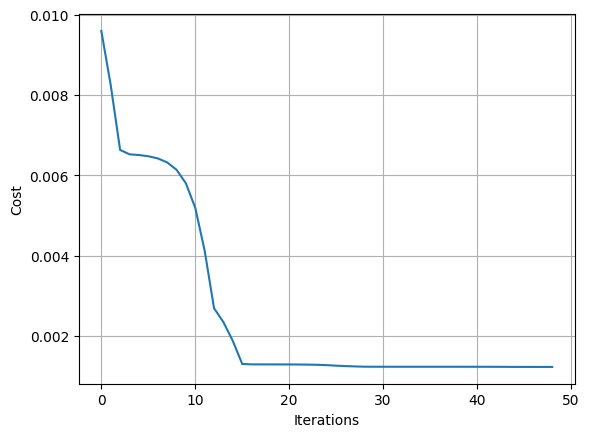

In [131]:
plot(T.J)
grid(1)
xlabel("Iterations")
ylabel("Cost")

When we evaluate the gradient at our solution, we can see that the values are quite small. This makes sense because the minimum in the cost function should be flat and the magnitude of the gradient tells us the rate of change of the function at that point.

In [132]:
NN.costFunctionPrime(X, y)

(array([[-2.93653735e-06, -8.42501367e-06,  9.79711052e-06],
        [-1.69207052e-06, -3.46889348e-06,  3.61670986e-06]]),
 array([[-6.02907919e-07],
        [ 1.43626274e-06],
        [-3.49800669e-07]]))

Our model is now much more accurate than before! We can even try to find the optimal # hours of sleep and studying to maximize our test score :)

In [133]:
NN.forward(X) # model's predicted test scores

array([[0.7499909 ],
       [0.85351343],
       [0.89351738]])

In [134]:
y # actual test scores

array([[0.75],
       [0.82],
       [0.93]])

In [135]:
# test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100) # 100 evenly spaced numbers from 0 - 10
hoursStudy = linspace(0, 5, 100) # 100 evenly spaced numbers from 0 - 5

# normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep / 10.
hoursStudyNorm = hoursStudy / 5.

# Create 2D versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

# join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [136]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

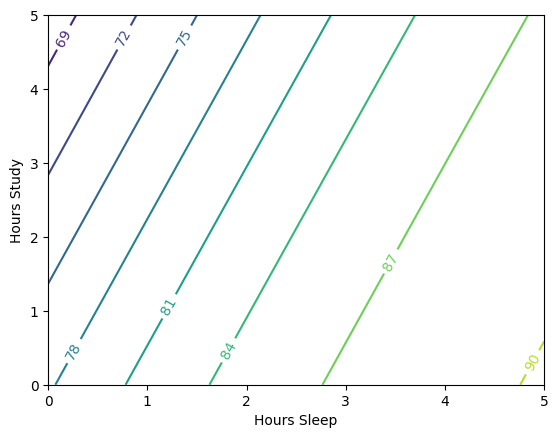

In [137]:
# make a contour plot
yy = np.dot(hoursStudy.reshape(100, 1), np.ones((1, 100)))
xx = np.dot(hoursStudy.reshape(100, 1), np.ones((1, 100))).T

CS = contour(xx, yy, 100 * allOutputs.reshape(100, 100))
clabel(CS, inline=1)
xlabel('Hours Sleep')
ylabel('Hours Study')

In [138]:
!pip install PyQt5
!pip install PySide2

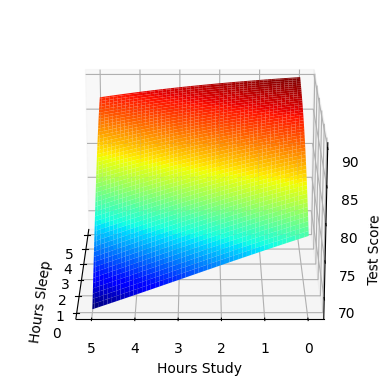

In [139]:
# 3D plot:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(xx, yy, 100 * allOutputs.reshape(100, 100), cmap = cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

ax.view_init(azim=180, elev=20)
plt.show()

# **Part 7: Overfitting, Testing, and Regularization**

Observations consist of **signal** and **noise**. The signal is the data we're interested in, but noise (many other factors) may cover the signal. If we can make our model fit the signal and not the noise, we should be able to avoid overfitting.

In [140]:
NN = Neural_Network()

# new data with 1 more example
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

Text(0, 0.5, 'Test Score')

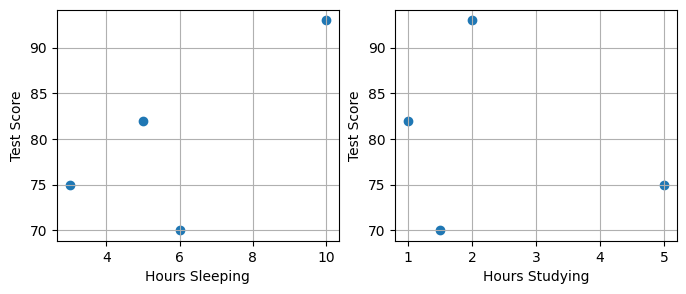

In [141]:
fig = figure(0, (8, 3)) # (figure number, (width, height))

subplot(1, 2, 1) # creates a subplot within a figure; (# rows, # cols, idx of subplot)
scatter(X[:,0], y) # creates scatterplot with 1st arg as x vals and 2nd arg as y vals
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(1,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')


In [142]:
# normalize
X = X / np.amax(X, axis = 0)
y = y / 100

In [143]:
# train model
T = trainer(NN)
T.train(X, y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 155
         Function evaluations: 172
         Gradient evaluations: 172


Text(0, 0.5, 'Cost')

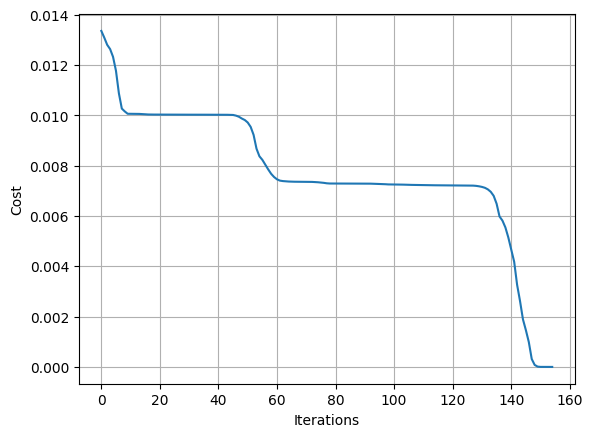

In [144]:
# plot cost during training
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [145]:
# test network for various combinations of sleep/study
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

# normalize data
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

# create 2D versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

# join into a single input matrix
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [146]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

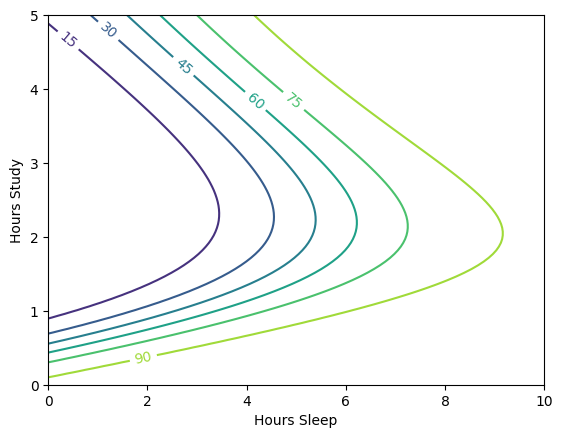

In [147]:
# contour plot
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

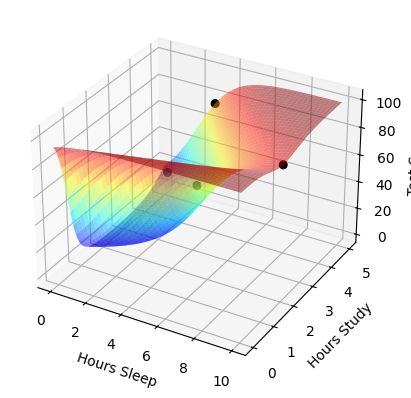

In [148]:
# 3D plot:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

One commonly used method is to split data into 2 portions: training and testing. Then, we can plot testing error and training error on Cost vs. Iterations and identify at what point overfitting starts.

In [149]:
# training data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

# testing data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

# normalize:
trainX = trainX / np.amax(trainX, axis=0)
trainY = trainY / 100

# normalize by max of training data:
testX = testX / np.amax(trainX, axis=0)
testY = testY / 100

In [150]:
# modified trainer class to check testing error during training
class trainer(object):
    def __init__(self, N):
        self.N = N

    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))

    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad

    def train(self, trainX, trainY, testX, testY):
        self.X = trainX
        self.y = trainY

        self.testX = testX
        self.testY = testY

        # empty lists to store training costs:
        self.J = []
        self.testJ = []

        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [151]:
# train network with new data
NN = Neural_Network()

T = trainer(NN)
T.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 137
         Gradient evaluations: 137


Text(0, 0.5, 'Cost')

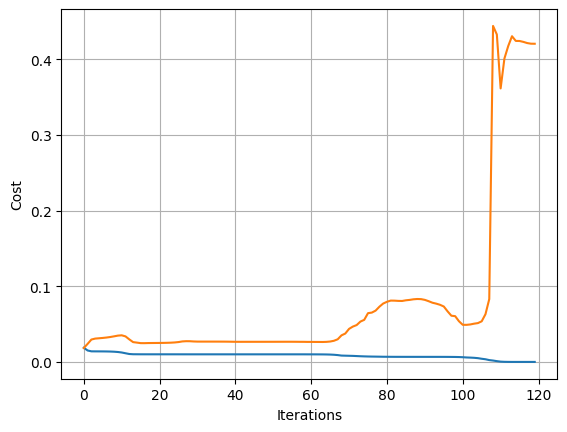

In [152]:
# plot cost during training:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

We can see that with more iterations, the cost of the testing data increases. This means that the model is becoming specialized in our training data.

Methods to reduce overfitting:

*   Use more training data. Rule of thumb: use 10 times as many examples as degrees of freedom. In our model, there are 9 weights, so use at least 90 examples.
*   **Regularlization**. One way to do this is by adding a term to our cost function that penalizes overly complex models. We will use a regularlization hyper parameter, **lambda**, that will allow us to tune the relative cost.


In [153]:
# regularization parameter
Lambda = 0.0001

In [154]:
# modified costFunction and costFunctionPrime
def costFunction(self, X, y):
    self.yHat = self.forward(X)

    # we don't want cost to inc with the # of examples, so normalize by dividing the error term by number of examples(X.shape[0])
    J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(sum(self.W1**2) + sum(self.W2**2))
    return J

def costFunctionPrime(self, X, y):
    self.yHat = self.forward(X)

    delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
    dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2 # add gradient of regularization term

    delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
    dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1 # add gradient of regularization term

    return dJdW1, dJdW2

In [155]:
# Neural Network class with modified costFunction and costFunctionPrime
class Neural_Network(object):
    def __init__(self, Lambda=0):
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3

        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)

        # regularization parameter
        self.Lambda = Lambda

    # propogate inputs through network
    def forward(self, X):
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3)
        return yHat

    # sigmoid activation function
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))

    # derivative of sigmoid function
    def sigmoidPrime(self,z):
        return np.exp(-z)/((1+np.exp(-z))**2)

    # compute J, the cost
    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J

    # compute derivate w/r/t W1 and W2
    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)

        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        # add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        # add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1

        return dJdW1, dJdW2

    # helper functions for interacting with other methods/classes
    def getParams(self):
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params

    def setParams(self, params):
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))

    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

Now when we train our model, it does not overfit as much to the training data!

In [156]:
NN = Neural_Network(Lambda=0.0001)

# make sure gradients our correct after making changes:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)

# should be less than 1e-8:
norm(grad-numgrad)/norm(grad+numgrad)

2.926024237791289e-10

In [157]:
T = trainer(NN)
T.train(X, y, testX, testY)

Optimization terminated successfully.
         Current function value: 0.002618
         Iterations: 63
         Function evaluations: 67
         Gradient evaluations: 67


Text(0, 0.5, 'Cost')

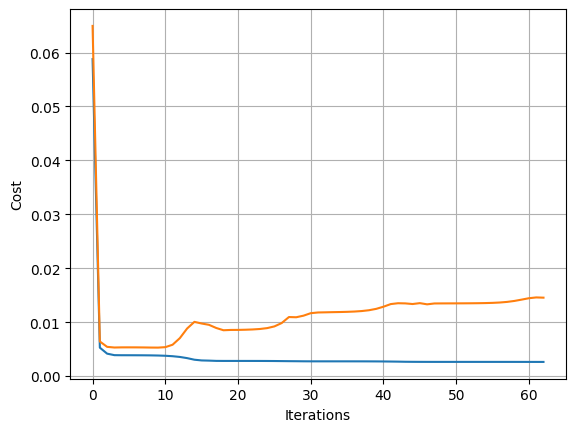

In [158]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [159]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

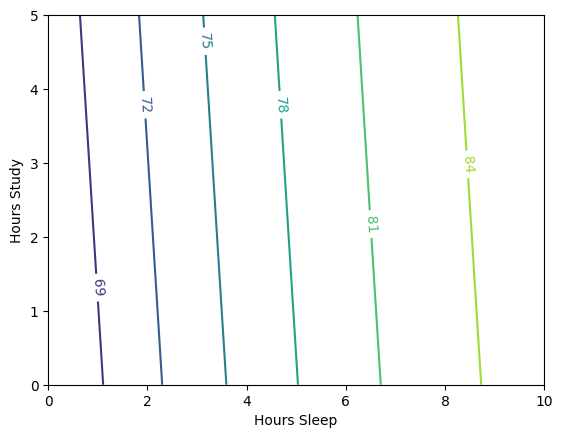

In [160]:
# contour plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

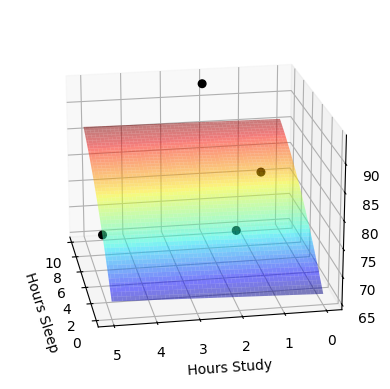

In [161]:
#3D plot:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

ax.view_init(azim=170, elev=20)
plt.show()

# **the end!!**